<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/GRF_perturbations/Notebooks/NeuralDensityEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/GRF_data/'

Mounted at /content/drive


In [ ]:
! pip install sbi

     |████████████████████████████████| 283 kB 5.4 MB/s 
     |████████████████████████████████| 718 kB 44.8 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=99d2124044d01186cd8ec0f193f221ec91ba5ddfdd039347fcb6339110a2e955
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but yo

In [ ]:
!pip3 install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 8.9 MB/s eta 0:02:09tcmalloc: large alloc 1147494400 bytes == 0x5589dee96000 @  0x7f3072976615 0x5589a5ee717c 0x5589a5fc747a 0x5589a5ee9f9d 0x5589a5fdbd4d 0x5589a5f5dec8 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f5dd30 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f5a719 0x5589a5fdcb76 0x5589a5f59d95 0x5589a5fdcb76 0x5589a5f59d95 0x5589a5fdcb76 0x5589a5f59d95 0x5589a5eebce9 0x5589a5f2f579 0x5589a5eea902 0x5589a5f5dc4d 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f5a719 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f598f6 0x5589a5eeb7aa 0x5589a5f59b4f 0x5589a5f58a2e
     |█████████████████               | 1055.7 MB 52.8 MB/s eta 0:00:18tcmalloc: large alloc 1434370048 bytes == 0x558a234ec000 @  0x7f3072976615 0x5589a5ee717c 0x5589a5fc747a 0x5589a5ee9f9d 0x5589a5fdbd4d 0x5589a5f5dec8 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f5dd30 0x5589a5f58a2e 0x5589a5eeb88a 0x5589a5f5a719 0x5589a5fdcb76 0x5589a5f59

In [ ]:
!pip3 install torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 17.6 MB 31 kB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


In [ ]:
!pip install corner

In [ ]:
import torch
import corner
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

# Prepare dataset

In [ ]:
import numpy as np

In [ ]:
grid_size=128 # resolution of logA,Beta axes
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
Phase_seeds_number=100 # number of random seeds that would ensure statistical significance of estimated spectrum mean and uncertainties

Spectra_grid=np.load(Folder+'Spectra_grid.npz')['arr_0']

In [ ]:
theta=np.zeros((*Spectra_grid.shape[:2],2))
for i,logA in enumerate(logA_array):
  for j,Beta in enumerate(Beta_array):
      theta[i,j,0]=logA
      theta[i,j,1]=Beta

In [ ]:
theta=np.repeat(theta,Spectra_grid.shape[2]).reshape((*Spectra_grid.shape[:2],2,Spectra_grid.shape[2]))
theta=np.moveaxis(theta,-1,-2)

In [ ]:
theta.shape

(128, 128, 100, 2)

In [ ]:
flat_Dataset=Spectra_grid.flatten().reshape((Spectra_grid.size//Spectra_grid.shape[-1],Spectra_grid.shape[-1]))
flat_theta=theta.flatten().reshape((theta.size//2,2))

In [ ]:
flat_Dataset.shape

(1638400, 46)

In [ ]:
flat_theta.shape

(1638400, 2)

# train SNPE

In [ ]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

In [ ]:
num_dim = 2
prior = utils.BoxUniform(low=torch.tensor([logA_array.min(),Beta_array.min()]), high=torch.tensor([logA_array.max(),Beta_array.max()]))
inference = SNPE(prior=prior)

In [ ]:
inference = inference.append_simulations(torch.tensor(flat_theta,dtype=torch.float32), torch.tensor(flat_Dataset,dtype=torch.float32))

In [ ]:
density_estimator = inference.train()

 Training neural network. Epochs trained: 29

KeyboardInterrupt: ignored

In [ ]:
from copy import deepcopy
density_estimator = deepcopy(inference._neural_net)

In [ ]:
posterior = inference.build_posterior(density_estimator)

In [ ]:
import pickle

with open(Folder+"Tau_Var_posterior_29ep.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [ ]:
logA_index=111
Beta_index=95
print('logA={:.2f} Beta={:.2f}'.format(logA_array[logA_index],Beta_array[Beta_index]))

logA=-7.30 Beta=3.52


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

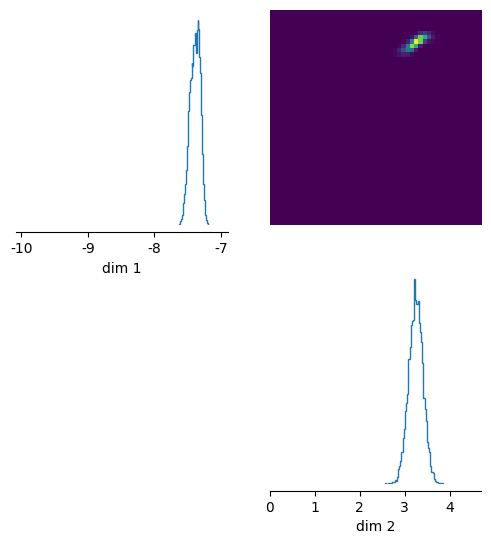

In [ ]:
observation=Spectra_grid[logA_index,Beta_index,0]
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples, limits=[[logA_array.min(),logA_array.max()],[Beta_array.min(),Beta_array.max()]], figsize=(6,6))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl


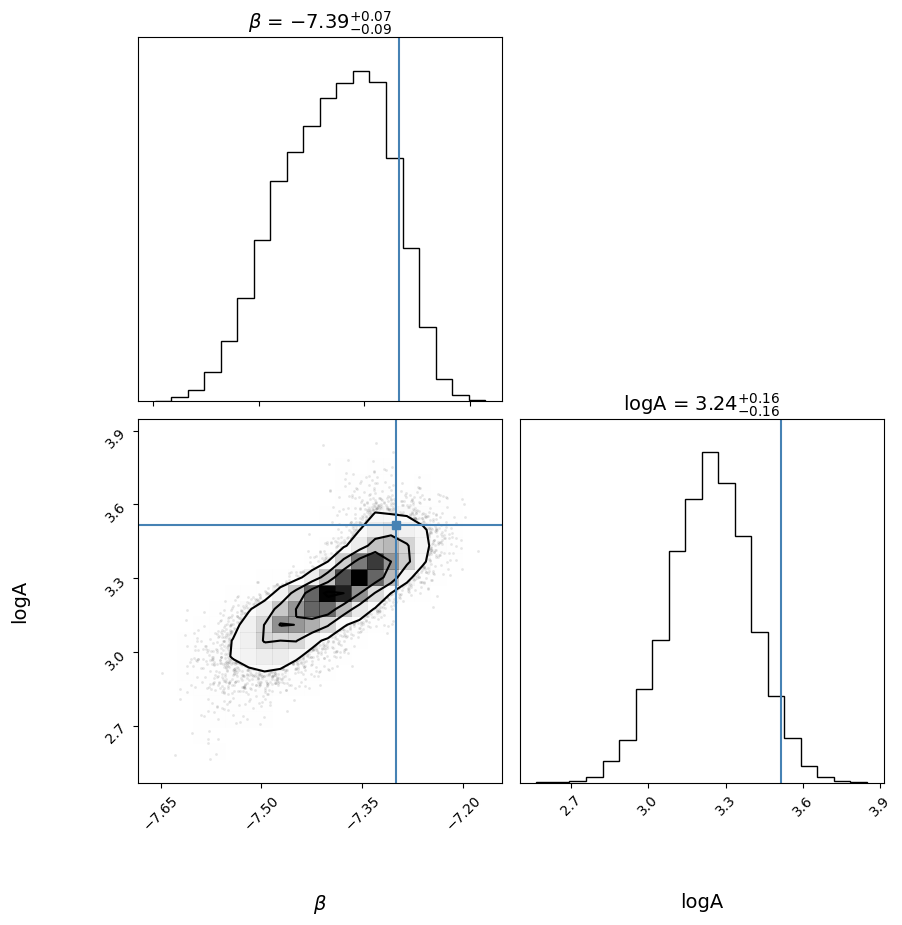

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.array(samples)
, show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[logA_array[logA_index],Beta_array[Beta_index]])
plt.show()

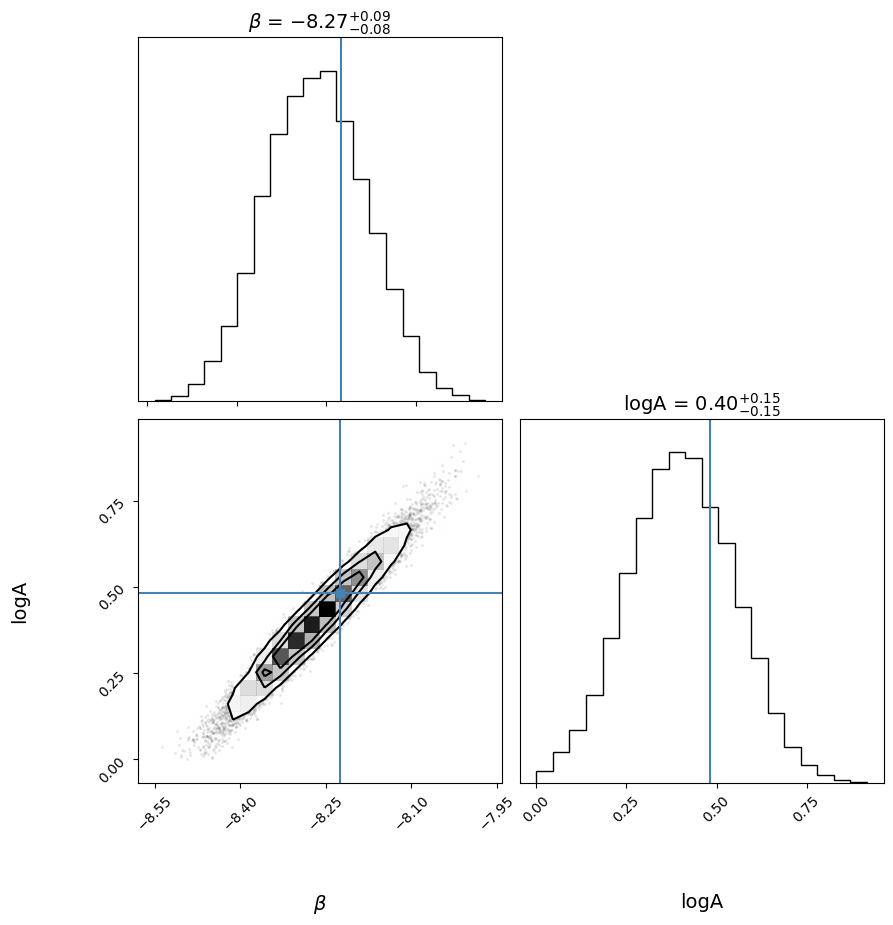

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.array(samples)
, show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[logA_array[logA_index],Beta_array[Beta_index]])
plt.show()

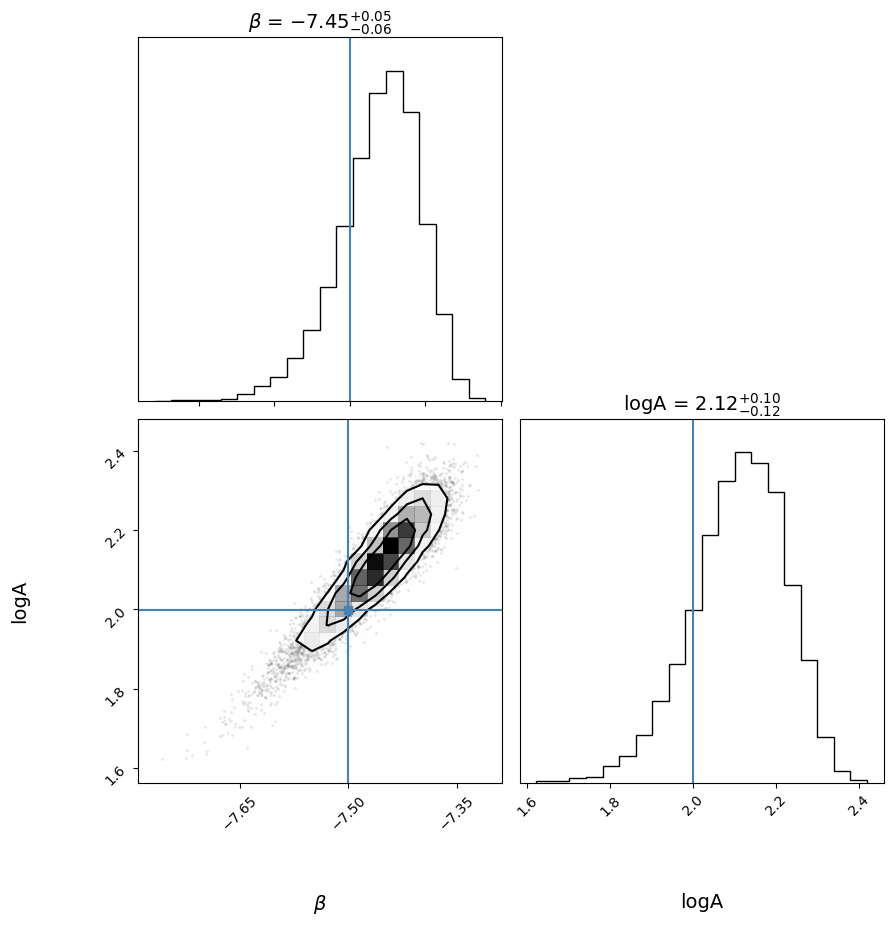

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.array(samples)
, show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[logA_array[logA_index],Beta_array[Beta_index]])
plt.show()

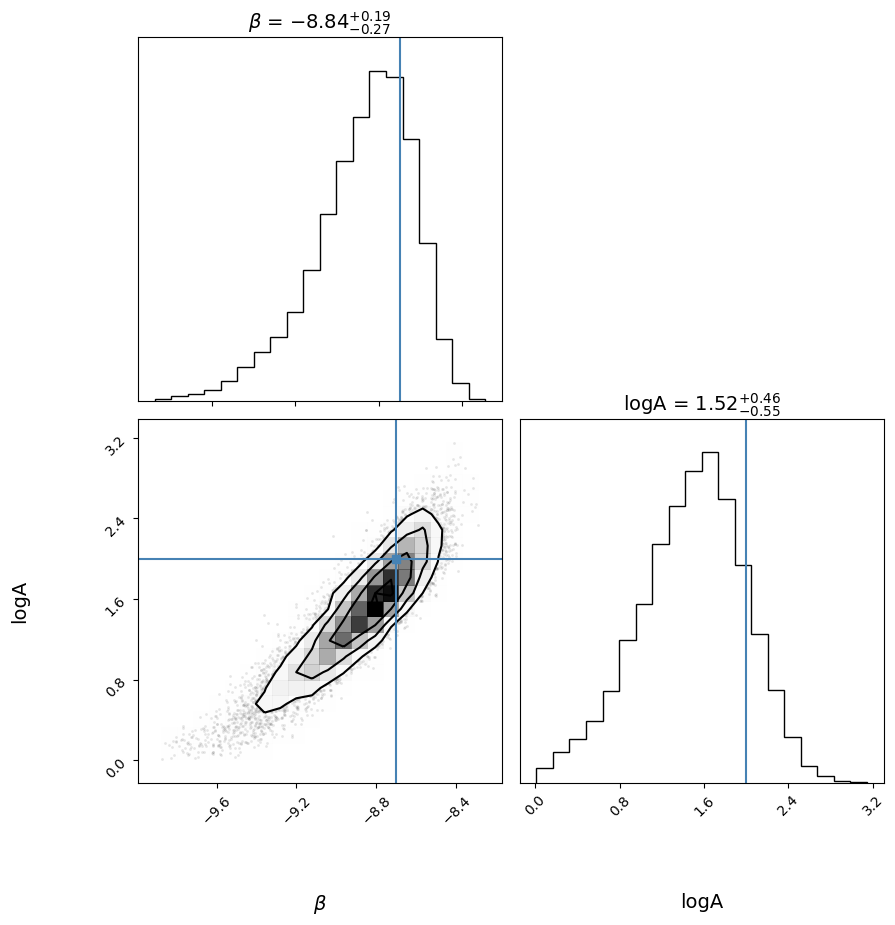

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.array(samples)
, show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[logA_array[logA_index],Beta_array[Beta_index]])
plt.show()